In [1]:
!pip install spectral
!pip install einops
!pip install records
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 212 kB 7.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 514 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 158 kB 6.9 MB/s 
     |████████████████████████████████| 48 kB 6.4 MB/s 
  Created wheel for openpyxl: filename=openpyxl-2.4.11-py2.py3-none-any.whl size=222838 sha256=aa75b395bc25e561130308b466a75d46810a6beaa2aad045a0e58c164755a5e6
  Stored in directory: /root/.cache/pip/wheels/3d/07/23/c0b52cb4c5e7abd1d8b325330224ee74b8c7000de6ee907df6
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=bf242c4576d805b930ad0ed9ffc50467d8860df34d466539dcf30ef73c16a47b
  Stored in directory: /root/.cache/pip/wheels/56/ea/58/

In [2]:
import sys
sys.path.append("./../")
from torch.nn import LayerNorm, Linear, Dropout, Softmax
from einops import rearrange, repeat
import copy
from timm.models.layers import DropPath, trunc_normal_
from pathlib import Path
import re
import torch.backends.cudnn as cudnn
import records
import matplotlib.pyplot as plt
from torchsummary import summary
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from operator import truediv
import math
from PIL import Image
import time
import torchvision.transforms.functional as TF
from torch.nn.parameter import Parameter
from sklearn.decomposition import PCA
from scipy.io import loadmat as loadmat
from scipy import io
import torch.utils.data as dataf
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch import einsum
import random
import numpy as np
import os
cudnn.deterministic = True
cudnn.benchmark = False


MFT WITH CHANNEL TOKENIZATION

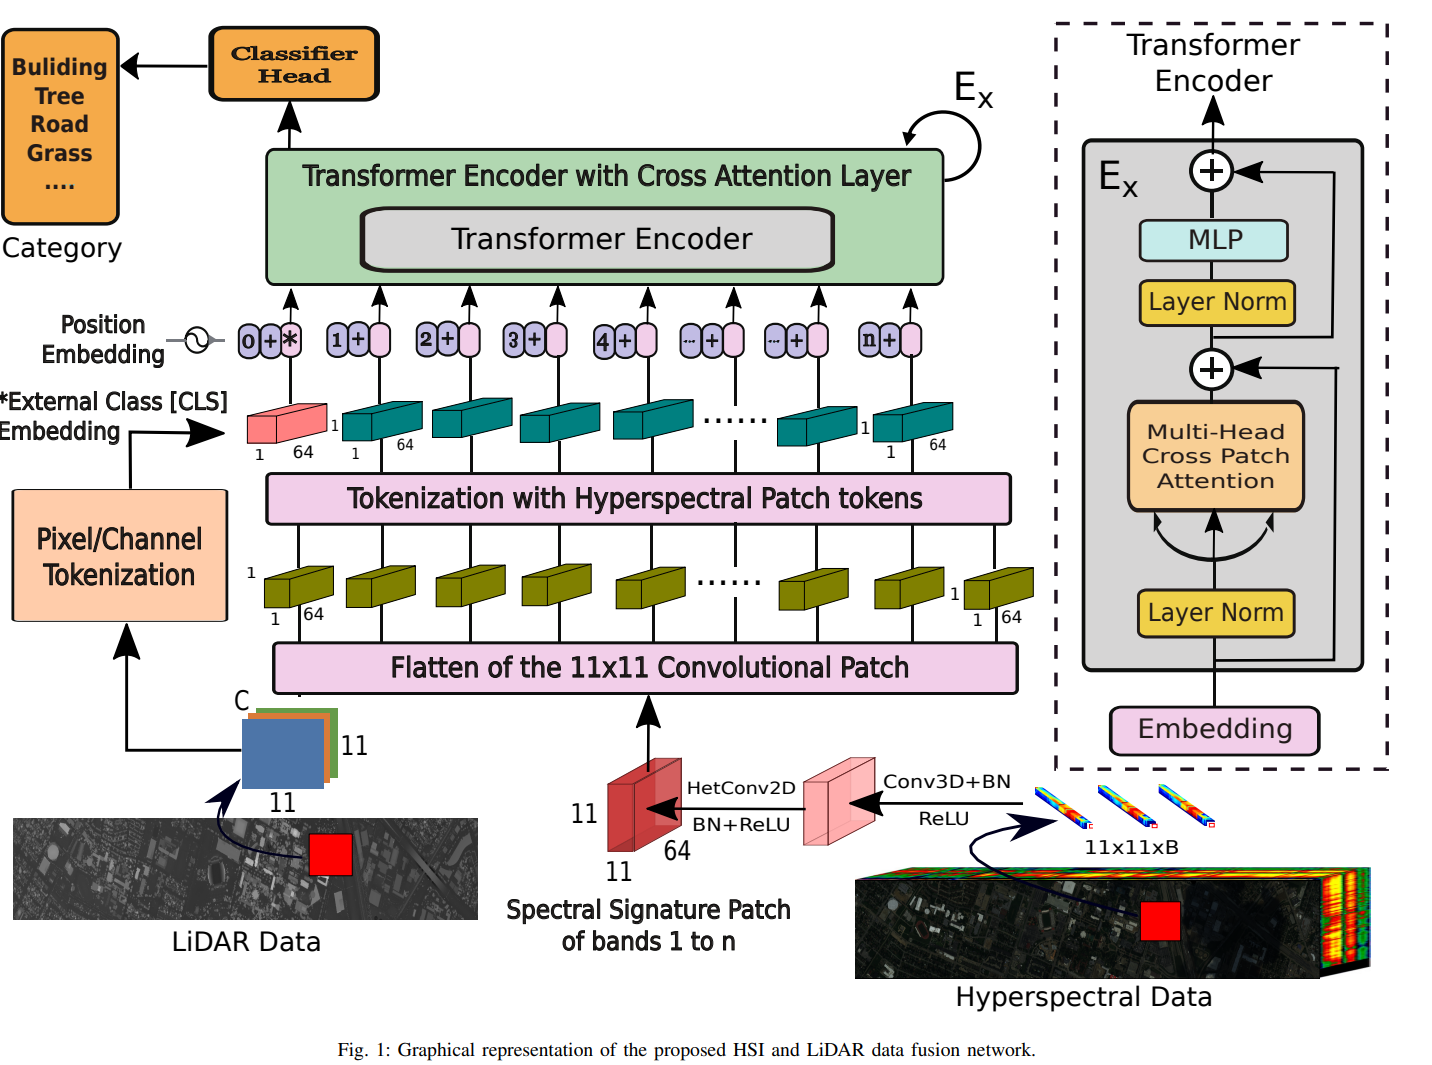

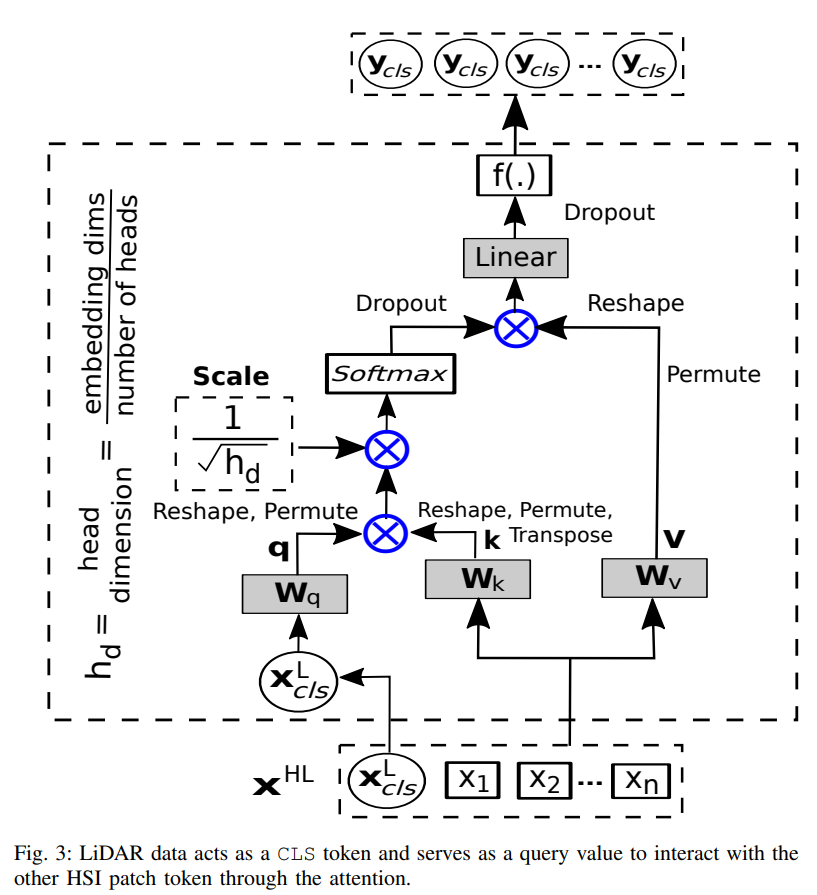

In [7]:
from torch.nn import LayerNorm,Linear,Dropout,Softmax
import copy

def INF(B,H,W):
  return -torch.dig(torch.tensor(float("inf")).cuda().repeat(H),0).unsqueeze(0).repeat(B*W,1,1)

class HeConv(nn.Module):#具体使用是在MFT中的conv6
  def __init__(self,in_channels,out_channels,kernel_size=3,stride=1,padding=None,bias=None,p=64,g=64):
    super(HeConv,self).__init__()
    # Groupwise Convolution
    self.gwc = nn.Conv2d(in_channels,out_channels,kernel_size=kernel_size,groups=g,padding=kernel_size//3,stride=stride)
    # Pointwise Convolution
    self.pwc = nn.Conv2d(in_channels,out_channels,kernel_size=1,groups=p,stride=stride)
  def forward(self,x):
    return self.gwc(x) + self.pwc(x)
class MCrossAttention(nn.Module):
  def __init__(self,dim,num_heads=8,qkv_bias=False,qk_scale=None,atten_drop=0.1,proj_drop=0.1):
    super().__init__()
    self.num_heads = num_heads
    head_dim = dim // num_heads
    self.scale = qk_scale or head_dim ** -0.5

    self.wq = nn.Linear(head_dim,dim,bias=qkv_bias)
    self.wk = nn.Linear(head_dim,dim,bias=qkv_bias)
    self.wv = nn.Linear(head_dim,dim,bias=qkv_bias)
    self.proj = nn.Linear(dim*num_heads,dim)
    self.proj_drop = nn.Dropout(proj_drop)
  def forward(self,x):
    B,N,C = x.shape
    print("B:{}, N:{}, C:{}".format(B,N,C))
    q = self.wq(x[:, 0:1, ...].reshape(B, 1, self.num_heads, C//self.num_heads)).permute(0,2,1,3)#（B,N,C）>(B,1,C)>(B,1,nh,C/nh)>(B,nh,1,C/nh)。注：这里是用第二维的0：1作为q,是为了更好的融合多源数据信息。图中可见。
    #"..."表示后面的不变；reshape中可以对目标矩阵某一项进行拆分self.num_heads * C//self.num_heads=C；permute可以直接改变顺序
    print("q.shape:",q.shape)
    k = self.wk(x.reshape(B, N, self.num_heads, C // self.num_heads)).permute(0,2,1,3)# BNC -> BNH(C/H) -> BHN(C/H)
    print("k.shape:",k.shape)
    v = self.wv(x.reshape(B, N, self.num_heads, C // self.num_heads)).permute(0,2,1,3)# BNC -> BNH(C/H) -> BHN(C/H)
    print("v.shape:",v.shape)
    attn = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale
    attn = attn.softmax(dim=1)
    x = torch.einsum('bhij,bhjd->bhid', attn, v).transpose(1,2)#torch.transpose()是交换指定的两个维度的内容，permute()则可以一次性交换多个维度
    x = x.reshape(B, 1, C*self.num_heads)# (BH1N @ BHN(C/H)) -> BH1(C/H) -> B1H(C/H) -> B1C
    x = self.proj(x)
    x = self.proj_drop(x)
    return x

class Mlp(nn.Module):
  def __init__(self,dim):
    super(Mlp,self).__init__()
    self.fc1 = Linear(dim,512)
    self.fc2 = Linear(512,dim)
    self.act_fn = nn.GELU()
    self.dropout = Dropout(0.1)
    self._init_weights()

  def _init_weights(self):
    nn.init.xavier_uniform_(self.fc1.weight)
    nn.init.xavier_uniform_(self.fc2.weight)
    nn.init.normal_(self.fc1.bias,std=1e-6)
    nn.init.normal_(self.fc2.bias,std=1e-6)
  def forward(self,x):
    x = self.fc1(x)
    x = self.act_fn(x)
    x = self.dropout(x)
    x = self.fc2(x)
    x = self.dropout(x)
    return x

class Block(nn.Module):
  def __init__(self,dim):
    super(Block,self).__init__()
    self.hidden_size = dim
    self.attention_norm = LayerNorm(dim, eps=1e-6)
    self.ffn_norm = LayerNorm(dim, eps=1e-6)
    self.ffn = Mlp(dim)
    self.attn = MCrossAttention(dim=dim)
  def forward(self,x):
    h = x
    x = self.attention_norm(x)
    x = self.attn(x)
    x = x + h
    h = x
    x = self.ffn_norm(x)
    x = self.ffn(x)
    x = x + h
    return x
class TransformerEncoder(nn.Module):
  def __init__(self,dim,num_heads=8,mlp_ratio=4.,qkv_bias=False,qk_scale=None,drop=0.1,attn_drop=0.1,drop_path=0.1,
               act_layer=nn.GELU,norm_layer=nn.LayerNorm,has_mlp=False):
    super().__init__()
    self.layer = nn.ModuleList()
    self.encoder_norm = LayerNorm(dim, eps=1e-6)
    for _ in range(2):
      layer = Block(dim)#表示处理过程包含了两个Block
      self.layer.append(copy.deepcopy(layer))
  def forward(self,x):
      print(self.layer)
      for layer_block in self.layer:#大概意思为：layer_block就是一个"完整"的处理过程(两个Block)
        x = layer_block(x)
      encoded = self.encoder_norm(x)
      print("encoded.shape:",encoded.shape)

      return encoded[:,0]#这里的意思是将第一个token（cls_token）提取出来用于分类

In [8]:
#单独测试TransformerEncoder时，便只需要考虑dim这一个参数
a1 = torch.randn(819,5,64)
MD = TransformerEncoder(64)
i = MD(a1)
print(i.shape)

ModuleList(
  (0): Block(
    (attention_norm): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
    (ffn_norm): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
    (ffn): Mlp(
      (fc1): Linear(in_features=64, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=64, bias=True)
      (act_fn): GELU(approximate=none)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (attn): MCrossAttention(
      (wq): Linear(in_features=8, out_features=64, bias=False)
      (wk): Linear(in_features=8, out_features=64, bias=False)
      (wv): Linear(in_features=8, out_features=64, bias=False)
      (proj): Linear(in_features=512, out_features=64, bias=True)
      (proj_drop): Dropout(p=0.1, inplace=False)
    )
  )
  (1): Block(
    (attention_norm): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
    (ffn_norm): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
    (ffn): Mlp(
      (fc1): Linear(in_features=64, out_features=512, bias=True)
      (fc2

In [ ]:
class MFT(nn.Module):
  def __init__(self,FM,NC,NCLidar,Classes,HSIOnly):
    super(MFT,self).__init__()
    self.HSIOnly = HSIOnly
    self.conv5 = nn.Sequential(
        nn.Conv3d(1,8,(9,3,3),padding=(0,1,1),stride=1),
        nn.BatchNorm3d(8),
        nn.ReLU()
    )
    self.conv6 = nn.Sequential(
        HeConv(8*(NC-8),FM*4,
               p=1,
               g=(FM*4)//4 if (8 * (NC - 8))%FM == 0 else (FM*4)//8,
               ),
        nn.BatchNorm2d(FM*4),
        nn.ReLU()
    )
    self.last_BatchSize = NC//2//2//2
    self.lidarConv = nn.Sequential(
        nn.Conv2d(NCLidar,64,3,1,1),
        nn.BatchNorm2d(64),
        nn.GELU()
    )
    self.ca = TransformerEncoder(FM*4)
    self.out3 = nn.Linear(FM*4,Classes)
    self.position_embeddings = nn.Parameter(torch.randn(1,4+1,FM*4))#（1，5，64）
    self.dropout = nn.Dropout(0.1)
    torch.nn.init.xavier_uniform_(self.out3.weight)
    torch.nn.init.normal_(self.out3.bias,std=1e-6)
    self.token_wA = nn.Parameter(torch.empty(1,4,64),requires_grad=True)
    torch.nn.init.xavier_normal_(self.token_wA)
    self.token_wV = nn.Parameter(torch.empty(1,64,64),requires_grad=True)
    torch.nn.init.xavier_normal_(self.token_wV)
    self.token_wA_L = nn.Parameter(torch.empty(1,1,64),requires_grad=True)
    torch.nn.init.xavier_normal_(self.token_wA_L)
    self.token_wV_L = nn.Parameter(torch.empty(1,64,64),requires_grad=True)
    torch.nn.init.xavier_normal_(self.token_wV_L)
  def forward(self,x1,x2):
    print("输入数据的x1.shape:",x1.shape,"| x2.shape:",x2.shape)
    x1 = x1.reshape(x1.shape[0],-1,patchsize,patchsize)
    print("第一步处理后数据的x1.shape:",x1.shape,"| x2.shape:",x2.shape)
    x1 = x1.unsqueeze(1)
    print("第二步处理后数据的x1.shape:",x1.shape,"| x2.shape:",x2.shape)
    x2 = x2.reshape(x2.shape[0],-1,patchsize,patchsize)
    print("第三步处理后数据的x1.shape:",x1.shape,"| x2.shape:",x2.shape)
    x1 = self.conv5(x1)
    print("第四步处理后数据的x1.shape:",x1.shape,"| x2.shape:",x2.shape)
    x1 = x1.reshape(x1.shape[0],-1,patchsize,patchsize)
    print("第五步处理后数据的x1.shape:",x1.shape,"| x2.shape:",x2.shape)

    x1 = self.conv6(x1)
    print("Conv6处理HSI后数据的x1.shape:",x1.shape,"| x2.shape:",x2.shape)
    x2 = self.lidarConv(x2)
    print("LidarConv处理雷达Liadr后数据的x1.shape:",x1.shape,"| x2.shape:",x2.shape)
    x2 = x2.reshape(x2.shape[0],-1,patchsize**2)
    print("x2reshape后数据的x1.shape:",x1.shape,"| x2.shape:",x2.shape)
    x2 = x2.transpose(-1, -2)
    print("x2变序后数据的x1.shape:",x1.shape,"| x2.shape:",x2.shape)
    print("_____________________________________________________________________________")
    print("                                       ")
    wa_L = self.token_wA_L.expand(x1.shape[0],-1,-1)#(819,1,64)
    print("self.token_wA_L.shape:",self.token_wA_L.shape)
    print("wa_L.shape:",wa_L.shape)
    wa_L = rearrange(wa_L, 'b h w -> b w h')  # Transpose
    print("转换之后的wa_L.shape为：",wa_L.shape)
    print("...........................................................................")
    A_L = torch.einsum('bij,bjk->bik', x2, wa_L)
    A_L = rearrange(A_L, 'b h w -> b w h')  # Transpose
    A_L = A_L.softmax(dim=-1)
    print("A_L.shape:",A_L.shape)
    wv_L = self.token_wV_L.expand(x2.shape[0],-1,-1)
    VV_L = torch.einsum('bij,bjk->bik', x2, wv_L)
    print("VV_L.shape:",VV_L.shape)
    x2 = torch.einsum('bij,bjk->bik', A_L, VV_L)#(819,1,64)可以理解为生成CLS_Token,或者生成CLS_Token的前奏
    print("x2.shape",x2.shape)
    x1 = x1.flatten(2)
    print("x1.shape",x1.shape)
    #_________________________________________________________________________________________
    #x1已经变为([819, 64, 121])，忽略819，可将每个batch_size看作121个（1，1，64）的Token
    #x1已经变为([819, 1, 64])，忽略819，可将每个batch_size看作1个（1，1，64）的Token
    #_________________________________________________________________________________________
    print("_____________________________________________________________________________")
    print("                                       ")
    x1 = x1.transpose(-1, -2)
    print("x1转换之后的shape为：",x1.shape)
    wa = self.token_wA.expand(x1.shape[0],-1,-1)
    print("self.token_wA.shape:",self.token_wA.shape)
    wa = rearrange(wa, 'b h w -> b w h')  # Transpose
    print("wa.shape:",wa.shape)
    A = torch.einsum('bij,bjk->bik', x1, wa)
    A = rearrange(A, 'b h w -> b w h')  # Transpose
    A = A.softmax(dim=-1)
    print("A.shape:",A.shape)
    wv = self.token_wV.expand(x1.shape[0],-1,-1)
    print("wv.shape:",wv.shape)
    VV = torch.einsum('bij,bjk->bik', x1, wv)
    print("VV.shape:",VV.shape)
    T = torch.einsum('bij,bjk->bik', A, VV)
    print("T.shape:",T.shape)
    x = torch.cat((x2, T), dim = 1) #[b,n+1,dim]
    print("x.shape:",x.shape)
    print("_______________________________________________________________")
    print("                                ")
    embeddings = x + self.position_embeddings
    print("self.position_embeddings.shape:",self.position_embeddings.shape)
    print("embeddings.x.shape:",embeddings.shape)
    embeddings = self.dropout(embeddings)
    print("embeddings.shape after dropout:",embeddings.shape)
    x = self.ca(embeddings)#transformerencoder
    print("after transformerencoder x.shape:",x.shape)
    x = x.reshape(x.shape[0],-1)
    print("x.shape after reshape:",x.shape)
    out3 = self.out3(x)
    print("after out3 x.shape:",out3.shape)
    return out3


In [ ]:
FM = 16
HSIOnly = False
NC = 63
NCLIDAR = 1
patchsize = 11
batchsize = 64
testSizeNumber = 500
EPOCH = 10
BandSize = 1
LR = 5e-4
t1 = torch.randn(819, 11, 11, 63)
t2 = torch.randn(819, 11, 11, 1)
net1 = MFT(FM, NC, NCLIDAR, 16, HSIOnly)
y = net1(t1,t2)
print(y.shape)

输入数据的x1.shape: torch.Size([819, 11, 11, 63]) | x2.shape: torch.Size([819, 11, 11, 1])
第一步处理后数据的x1.shape: torch.Size([819, 63, 11, 11]) | x2.shape: torch.Size([819, 11, 11, 1])
第二步处理后数据的x1.shape: torch.Size([819, 1, 63, 11, 11]) | x2.shape: torch.Size([819, 11, 11, 1])
第三步处理后数据的x1.shape: torch.Size([819, 1, 63, 11, 11]) | x2.shape: torch.Size([819, 1, 11, 11])
第四步处理后数据的x1.shape: torch.Size([819, 8, 55, 11, 11]) | x2.shape: torch.Size([819, 1, 11, 11])
第五步处理后数据的x1.shape: torch.Size([819, 440, 11, 11]) | x2.shape: torch.Size([819, 1, 11, 11])
Conv6处理HSI后数据的x1.shape: torch.Size([819, 64, 11, 11]) | x2.shape: torch.Size([819, 1, 11, 11])
LidarConv处理雷达Liadr后数据的x1.shape: torch.Size([819, 64, 11, 11]) | x2.shape: torch.Size([819, 64, 11, 11])
x2reshape后数据的x1.shape: torch.Size([819, 64, 11, 11]) | x2.shape: torch.Size([819, 64, 121])
x2变序后数据的x1.shape: torch.Size([819, 64, 11, 11]) | x2.shape: torch.Size([819, 121, 64])
____________________________________________________________________________

In [ ]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torchvision import models
#from torchinfo import summary

In [ ]:
batchsize = 64
patchsize = 11
model = MFT(16, 144, 1, 15, False)
t1 = torch.randn(144,121)
t2 = torch.randn(1,121)
#t3 = model(t1,t2)

summary(model, [(144,121),(1,121)],device = 'cpu')

In [ ]:
x = torch.randn(5,5,8)
print(x.shape)
y = x[:, 0:1, ...]
print(y.shape)
t = y.reshape(5,1,2,4)
print(t.shape)
v = t.permute(0,2,1,3)
print(v.shape)

torch.Size([5, 5, 8])
torch.Size([5, 1, 8])
torch.Size([5, 1, 2, 4])
torch.Size([5, 2, 1, 4])


In [ ]:
DATASETS_WITH_HSI_PARTS = ['Berlin', 'Augsburg']
DATA2_List = ['SAR','DSM','MS']
os.environ["CUDA_VISIBLE_DEVICES"]="1"
# All datasets = "Houston","Trento","MUUFL","HoustonMS","AugsburgSAR","AugsburgDSM"
datasetNames = ["Trento"]

patchsize = 11
batchsize = 64
testSizeNumber = 500
EPOCH = 10
BandSize = 1
LR = 5e-4
FM = 16
HSIOnly = False
FileName = 'MFT'

def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

def reports (xtest,xtest2,ytest,name,model):
    pred_y = np.empty((len(ytest)), dtype=np.float32)
    number = len(ytest) // testSizeNumber
    for i in range(number):
        temp = xtest[i * testSizeNumber:(i + 1) * testSizeNumber, :, :]
        temp = temp.to(device)
        temp1 = xtest2[i * testSizeNumber:(i + 1) * testSizeNumber, :, :]
        temp1 = temp1.to(device)

        temp2 = model(temp,temp1)
        
        temp3 = torch.max(temp2, 1)[1].squeeze()
        pred_y[i * testSizeNumber:(i + 1) * testSizeNumber] = temp3.cpu()
        del temp, temp2, temp3,temp1

    if (i + 1) * testSizeNumber < len(ytest):

        temp = xtest[(i + 1) * testSizeNumber:len(ytest), :, :]
        temp = temp.to(device)
        temp1 = xtest2[(i + 1) * testSizeNumber:len(ytest), :, :]
        temp1 = temp1.to(device)

        temp2 = model(temp,temp1)
        temp3 = torch.max(temp2, 1)[1].squeeze()
        pred_y[(i + 1) * testSizeNumber:len(ytest)] = temp3.cpu()
        del temp, temp2, temp3,temp1

    pred_y = torch.from_numpy(pred_y).long()
    
    if name == 'Houston':
        target_names = ['Healthy grass', 'Stressed grass', 'Synthetic grass'
                        ,'Trees', 'Soil', 'Water', 
                        'Residential', 'Commercial', 'Road', 'Highway',
                        'Railway', 'Parking Lot 1', 'Parking Lot 2', 'Tennis Court',
                        'Running Track']
    elif name == 'Trento':
        target_names = ['Apples','Buildings','Ground','Woods','Vineyard',
                        'Roads']
    elif name == 'MUUFL' or name == 'MUUFLS' or name == 'MUUFLSR':
        target_names = ['Trees','Grass_Pure','Grass_Groundsurface','Dirt_And_Sand', 'Road_Materials','Water',"Buildings'_Shadow",
                    'Buildings','Sidewalk','Yellow_Curb','ClothPanels']
    elif name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'UP':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']

#     classification = classification_report(ytest, pred_y, target_names=target_names)
    oa = accuracy_score(ytest, pred_y)
    confusion = confusion_matrix(ytest, pred_y)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(ytest, pred_y)

    return confusion, oa*100, each_acc*100, aa*100, kappa*100

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
!pip install record

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import records

In [ ]:
for BandSize in [1]:
  for datasetName in datasetNames:
    print("----------------------------------Training for ",datasetName," ---------------------------------------------")
    try:
      os.makedirs(datasetName)
    except FileExistsError:
      pass
    data1Name = ''
    data2Name = ''
    if datasetName in ["Houston","Trento","MUUFL"]:
      data1Name = datasetName
      data2Name = 'LIDAR'
    else:
      for dataName in DATA2_List:
        dataNameToCheck = re.complie(dataName)
        matchObj = dataNameToCheck.search(datasetName)
        if matchObj:
          data1Name = datasetName.replace(dataName,"")
          data2Name = dataName

    HSI = io.loadmat("/content/drive/MyDrive/AI data/"+data1Name+'11x11/HSI_Tr.mat')
    TrainPatch = HSI['Data']
    print("输入HSI训练数据的shape为：",TrainPatch.shape)
    TrainPatch = TrainPatch.astype(np.float32)
    NC = TrainPatch.shape[3]
    print('NC:',NC)# NC is number of bands

    LIDAR = io.loadmat('/content/drive/MyDrive/AI data/'+data1Name+'11x11/'+data2Name+'_Tr.mat')
    TrainPatch2 = LIDAR['Data']
    TrainPatch2 = TrainPatch2.astype(np.float32)
    print("输入LIDAR训练数据的shape为：",TrainPatch2.shape)
    NCLIDAR = TrainPatch2.shape[3] # NC is number of bands
    print('NCLIDAR:',NCLIDAR)

    label = io.loadmat('/content/drive/MyDrive/AI data/'+data1Name+'11x11/TrLabel.mat')
    TrLabel = label['Data']
    print("输入的训练标签数据shape为：",TrLabel.shape)

    # Test data
    if data1Name in DATASETS_WITH_HSI_PARTS:
      i = 2
      basePath = "/content/drive/MyDrive/AI data/"+data1Name+'11x11/HSI_Te_Part'
      TestPatch = io.loadmat(basePath + str(i - 1) + '.mat')['Data']
      while True:
        my_file = Path(basePath + str(i) + '.mat')
        if my_file.exists():
          TestPatch = np.concatenate([TestPatch,io.loadmat(basePath + str(i) + '.mat')['Data']], axis = 0)
          i += 1
        else:
          break
    else:
      HSI = io.loadmat("/content/drive/MyDrive/AI data/"+data1Name+'11x11/HSI_Te.mat')
      TestPatch = HSI['Data']
    TestPatch = TestPatch.astype(np.float32)
    print("输入HSI测试数据的shape为：",TestPatch.shape)

    LIDAR = io.loadmat('/content/drive/MyDrive/AI data/'+data1Name+'11x11/'+data2Name+'_Te.mat')
    TestPatch2 = LIDAR['Data']
    TestPatch2 = TestPatch2.astype(np.float32)
    print("输入LIDAR测试数据的shape为：",TestPatch2.shape)

    label = io.loadmat('/content/drive/MyDrive/AI data/'+data1Name+'11x11/TeLabel.mat')
    TsLabel = label['Data']
    print("输入的测试标签数据shape为：",TsLabel.shape)

    # array to torch(train)
    TrainPatch1 = torch.from_numpy(TrainPatch).to(torch.float32)
    TrainPatch1 = TrainPatch1.permute(0,3,1,2)#将波段维度调整到第二位
    #print("调整后的shape为：",TrainPatch1.shape)
    TrainPatch1 = TrainPatch1.reshape(TrainPatch1.shape[0],TrainPatch1.shape[1],-1).to(torch.float32)#将影像高宽值乘到一起（11，11）>(121)
    #print("第二次调整后的shape为：",TrainPatch1.shape)
    TrainPatch2 = torch.from_numpy(TrainPatch2).to(torch.float32)
    TrainPatch2 = TrainPatch2.permute(0,3,1,2)
    TrainPatch2 = TrainPatch2.reshape(TrainPatch2.shape[0],TrainPatch2.shape[1],-1).to(torch.float32)
    TrainLabel1 = torch.from_numpy(TrLabel)-1
    TrainLabel1 = TrainLabel1.long()
    TrainLabel1 = TrainLabel1.reshape(-1)
    # array to torch(test)
    TestPatch1 = torch.from_numpy(TestPatch).to(torch.float32)
    TestPatch1 = TestPatch1.permute(0,3,1,2)
    TestPatch1 = TestPatch1.reshape(TestPatch1.shape[0],TestPatch1.shape[1],-1).to(torch.float32)
    TestPatch2 = torch.from_numpy(TestPatch2).to(torch.float32)
    TestPatch2 = TestPatch2.permute(0,3,1,2)
    TestPatch2 = TestPatch2.reshape(TestPatch2.shape[0],TestPatch2.shape[1],-1).to(torch.float32)
    TestLabel1 = torch.from_numpy(TsLabel)-1
    TestLabel1 = TestLabel1.long()
    TestLabel1 = TestLabel1.reshape(-1)
    # dataloader process
    Classes = len(np.unique(TrainLabel1))
    dataset = dataf.TensorDataset(TrainPatch1,TrainPatch2,TrainLabel1)#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    if data1Name in ['Berlin']:
      train_loader = dataf.DataLoader(dataset, batch_size=batchsize, shuffle=True, num_workers= 0)
    else:
      train_loader = dataf.DataLoader(dataset, batch_size=batchsize, shuffle=True, num_workers= 2)
    print("HSI Train data shape = ", TrainPatch1.shape)
    print(data2Name + " Train data shape = ", TrainPatch2.shape)
    print("Train label shape = ", TrainLabel1.shape)

    print("HSI Test data shape = ", TestPatch1.shape)
    print(data2Name + " Test data shape = ", TestPatch2.shape)
    print("Test label shape = ", TestLabel1.shape)

    print("Number of Classes = ",Classes)
    KAPPA = []
    OA = []
    AA = []
    ELEMENT_ACC = np.zeros((3, Classes))

    set_seed(42)
    for iterNum in range(3):
      model = MFT(FM, NC, NCLIDAR, Classes, HSIOnly).to(device)#加载模型
      #summary(model, [(NC, patchsize**2),(NCLIDAR,patchsize**2)])
      optimizer = torch.optim.Adam(model.parameters(), lr=LR,weight_decay=5e-3)
      loss_func = nn.CrossEntropyLoss()  # the target label is not one-hotted
      scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.9)#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
      BestAcc = 0

      #torch.cuda.synchronize()
      start = time.time()
      # train and test the designed model
      for epoch in range(EPOCH):
        for step, (b_x1, b_x2, b_y) in enumerate(train_loader):
          # move train data to GPU
          b_x1 = b_x1.to(device)
          b_y = b_y.to(device)
          if HSIOnly:
            out1 = model(b_x1,  b_x2)
            loss = loss_func(out1, b_y)
          else:
            b_x2 = b_x2.to(device)
            out= model(b_x1, b_x2)
            loss = loss_func(out, b_y)
          optimizer.zero_grad()  # clear gradients for this training step
          loss.backward()  # backpropagation, compute gradients
          optimizer.step()  # apply gradients

          if step % 50 == 0:
            model.eval()
            pred_y = np.empty((len(TestLabel1)),dtype='float32')
            number = len(TestLabel1) // testSizeNumber#在测试时将测试集中的数据划分为500个/份。再将每份（500个）依次送入模型进行测试。其实就是测试集版的batch_size
            for i in range(number):
              temp = TestPatch1[i * testSizeNumber:(i + 1) * testSizeNumber, :, :]
              temp = temp.to(device)
              temp1 = TestPatch2[i * testSizeNumber:(i + 1) * testSizeNumber, :, :]
              temp1 = temp1.to(device)
              if HSIOnly:
                temp2 = model(temp, temp1)
                temp3 = torch.max(temp2, 1)[1].squeeze()
                pred_y[i * testSizeNumber:(i + 1) * testSizeNumber] = temp3.cpu()
                del temp, temp2, temp3
              else:
                temp2 = model(temp, temp1)
                temp3 = torch.max(temp2, 1)[1].squeeze()
                pred_y[i * testSizeNumber:(i + 1) * testSizeNumber] = temp3.cpu()
                del temp, temp1, temp2, temp3
            if (i + 1) * testSizeNumber < len(TestLabel1):
              temp = TestPatch1[(i + 1) * testSizeNumber:len(TestLabel1), :, :]
              temp = temp.to(device)
              temp1 = TestPatch2[(i + 1) * testSizeNumber:len(TestLabel1), :, :]
              temp1 = temp1.to(device)
              if HSIOnly:
                temp2 = model(temp, temp1)
                temp3 = torch.max(temp2, 1)[1].squeeze()
                pred_y[(i + 1) * testSizeNumber:len(TestLabel1)] = temp3.cpu()
                del temp, temp2, temp3
              else:
                temp2 = model(temp, temp1)
                temp3 = torch.max(temp2, 1)[1].squeeze()
                pred_y[(i + 1) * testSizeNumber:len(TestLabel1)] = temp3.cpu()
                del temp, temp1, temp2, temp3
              
            pred_y = torch.from_numpy(pred_y).long()
            accuracy = torch.sum(pred_y == TestLabel1).type(torch.FloatTensor) / TestLabel1.size(0)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.cpu().numpy(), '| test accuracy: %.4f' % (accuracy*100),'|iterNum:',int(iterNum))

            #save the parameters in network
            if accuracy > BestAcc:
              BeatAcc = accuracy
              torch.save(model.state_dict(), datasetName+'/net_params_'+FileName+'.pkl')
            
            model.train()
        scheduler.step()
      #torch.cuda.synchronize()
      end = time.time()
      print(end-start)
      Train_time = end-start

      # load the saved parameters
      model.load_state_dict(torch.load(datasetName+'/net_params_'+FileName+'.pkl'))
      model.eval()
      confusion, oa, each_acc, aa, kappa = reports(TestPatch1,TestPatch2,TestLabel1,datasetName,model)
      KAPPA.append(kappa)
      OA.append(oa)
      AA.append(aa)
      ELEMENT_ACC[iterNum, :] = each_acc
      torch.save(model, datasetName+'/best_model_'+FileName+'_BandSize'+str(BandSize)+'_Iter'+str(iterNum)+'.pt')

      print("OA = ", oa)
      print("----------" + datasetName + " Training Finished -----------")
      #records.record_output(OA, AA, KAPPA, ELEMENT_ACC,'./' + datasetName +'/'+FileName+'_BandSize'+str(BandSize)+'_Report_' + datasetName +'.txt')

----------------------------------Training for  Trento  ---------------------------------------------
输入HSI训练数据的shape为： (819, 11, 11, 63)
NC: 63
输入LIDAR训练数据的shape为： (819, 11, 11, 1)
NCLIDAR: 1
输入的训练标签数据shape为： (1, 819)
输入HSI测试数据的shape为： (29395, 11, 11, 63)
输入LIDAR测试数据的shape为： (29395, 11, 11, 1)
输入的测试标签数据shape为： (1, 29395)
HSI Train data shape =  torch.Size([819, 63, 121])
LIDAR Train data shape =  torch.Size([819, 1, 121])
Train label shape =  torch.Size([819])
HSI Test data shape =  torch.Size([29395, 63, 121])
LIDAR Test data shape =  torch.Size([29395, 1, 121])
Test label shape =  torch.Size([29395])
Number of Classes =  6
Epoch:  0 | train loss: 1.9761 | test accuracy: 1.2723 |iterNum: 0
Epoch:  1 | train loss: 1.1679 | test accuracy: 42.1636 |iterNum: 0
Epoch:  2 | train loss: 0.4046 | test accuracy: 43.3577 |iterNum: 0
Epoch:  3 | train loss: 0.3012 | test accuracy: 51.8353 |iterNum: 0
Epoch:  4 | train loss: 0.0698 | test accuracy: 64.4293 |iterNum: 0
Epoch:  5 | train loss: 0.1

In [ ]:
t1 = torch.randn(819, 11, 11, 63)
t2 = torch.randn(819, 11, 11, 1)
net1 = MFT(FM, NC, NCLIDAR, 16, HSIOnly)
y = net1(t1,t2)
print(y.shape)

torch.Size([819, 16])
